<a href="https://colab.research.google.com/github/AKShaffer/Group-2---Generative-AI-Tools-for-Drug-Repurposing-for-PD/blob/main/GAN_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##GAN Refinement of VAE-generated novel molecules

**Author:** Angela Shaffer<br>
**Date Created:** 2025/03/15<br>
**Last Modified:** 2020/03/15<br>

This code is the second half of a VAE-GAN model. The VAE model is found in Colab notebook *PD_VAE_BIOT670i.ipynb found here: https://github.com/AKShaffer/Group-2---Generative-AI-Tools-for-Drug-Repurposing-for-PD/tree/main/VAE

This notebook take the VAE-geneated smiles data to train a WGAN model. Generative Adversarial Networks are a generative AI consisting of two neural networks--a generator and a discriminator. The trained generator attempts to create fake smiles molecules to "fool" the discriminator and the the trained discriminator tries to identify and reject the fake molecules. The goal of GAN models is that through each round of training, both the generator and discriminator improve their learning with the generator creating more realistic "fake data" (fake smiles molecules in this case) while the discriminator improves its ability to distinguish between fake and real smiles molecules. As the generator and discriminator compete with each other, the loss value from each model should start to converge towards a similar loss value.


The novel molecules generated by the VAE were used as the training data for this WGAN model.
To ensure that the VAE-generated smiles training dataset is robust, the output from the VAE contains additional functions for calculating descriptors (i.e., qed, logP, and sas) and filtering out smiles that score below the qed threshold of 0.492 which is the literature determined minimum threshold for market approved drugs; refer to Bickerton et al. (2012) for additional information about QED scoring.


While this notebook utilizes VAE generated smiles as the training dataset, any csv containing smiles data may be used in this model. Follow the code comments in the "Load dataset" code block below for how to set this up for your own smiles dataset.


This WGAN model is adapted from the Keras paper [WGAN-GP with R-GCN for the generation of small molecular graphs](https://keras.io/examples/generative/wgan-graphs/) authored by Alexander Kensert (akensert). The majority of the functions in this notebook are derived from this Keras paper.

*Reference for QED mean threshold:* Bickerton, G. R., Paolini, G. V., Besnard, J., Muresan, S., & Hopkins, A. L. (2012). Quantifying the chemical beauty of drugs. Nature chemistry, 4(2), 90-98. (https://doi.org/10.1038/nchem.1243)

### Initialize and install modules

In [1]:
# Install packages:
!pip -q install rdkit-pypi
!pip -q install rdkit
!pip -q install Pillow


# Import packages:
'''
- rdkit: The main library for cheminformatics functionalities.
- rdkit.Chem: Provides functions specifically for chemical operations, including MolToSmiles
  (converting a molecule object to a SMILES string) and Draw (for visualizing molecules).
- rdkit.Chem.Draw: Contains tools for drawing chemical structures, such as IPythonConsole and
  MolsToGridImage.
- numpy: A fundamental library for numerical computations in Python, often used for working
  with arrays and matrices.
- tensorflow: A powerful library for machine learning, utilized here for building and training
  the Generative Adversarial Network (GAN).
- tensorflow.keras: A high-level API for building and training neural networks within
  TensorFlow.
- PIL: Python Imaging Library, also known as Pillow, provides image processing capabilities.
- ipywidgets: Used for creating interactive widgets in Jupyter notebooks.
- IPython.display: Allows displaying various types of content, like images and widgets, within
  the notebook.
- io: Handles input and output operations, such as working with files and streams.
- google.colab: If running on Google Colab, this library is used to mount Google Drive for data
  storage and access.
- os: Provides functions for interacting with the operating system, like managing files and
  directories.
- collections.Counter: A useful class for counting the frequency of items in a collection.
'''
import rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, BondType, Crippen, Descriptors, MolToSmiles
from rdkit.Chem import Draw, QED, rdmolops, rdMolDescriptors, RDConfig, SanitizeFlags, SanitizeMol
from rdkit.Chem.rdchem import AtomValenceException
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage, rdMolDraw2D, rdDepictor
import numpy as np
import os
import io
from io import BytesIO
import sys
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import csv

# Add the RDKit's Contrib directory to the Python path
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

from PIL import Image
import PIL
import ipywidgets as widgets
from IPython.display import display
import io

from google.colab import drive
drive.mount('/content/drive')
from collections import Counter


# RDKit Logging:
'''
RDLogger.DisableLog("rdApp.*") is used to disable certain log messages from RDKit, to reduce
clutter in the notebook's output.
'''
RDLogger.DisableLog("rdApp.*")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 15.3 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the training dataset

SMILES: C.CCCOC1CCC(O)O1


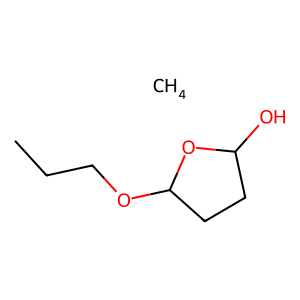

Num heavy atoms: 11


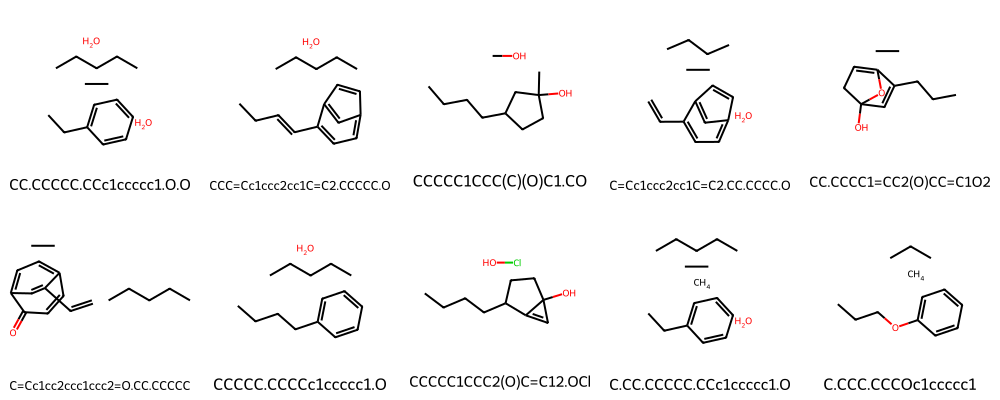

In [2]:
# Dataset
'''
The dataset in the original code was generated from a VAE model that was trained on market approved
Parkinson's Disease drugs and produced novel smiles molecules. The data file is named VAE_generated_molecules.csv
and is found at (https://github.com/AKShaffer/Group-2---Generative-AI-Tools-for-Drug-Repurposing-for-PD/tree/main/GAN).
Although there are features labeled in the columns, the GAN will only focus on the [smiles]
(https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) column.
'''

# Establishing the path to the dataset
'''
This variable stores the path to the CSV file containing the molecule data, specifically
SMILES strings. It is assumed that the SMILES strings are in the first column (index 0) of the
CSV.

For loading in your own smiles data, changed the csv_path to the path to your Google Drive.
Ensure to include any subfolders if they are on the path to your file. Your file may contain
as many columns as you'd like, but the first column *must* be the smiles column and it must
have the column header "smiles" without the quotes and in all lowercase.
'''
csv_path = '/content/drive/My Drive/VAE_GAN_Colab_Notebooks/Data/VAE_generated_molecules.csv'

# Loading the dataset
'''
- The code then opens the CSV file and reads its contents line by line, starting from the
  second line (f.readlines()[1:]).
- For each line, it splits the line by commas (,) and appends the second element
  (the SMILES string) to the data list. Now, the data list contains all the SMILES strings from
  the CSV file.
'''
data = []
with open(csv_path, "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[0])

# Visualizing a subset of molecules
'''
This part selects a specific molecule from the data list using an index (here, 10) and prints
its SMILES string and the number of heavy atoms.
'''
# Let's look at a molecule of the dataset;
smiles = data[10]
print("SMILES:", smiles)
molecule = Chem.MolFromSmiles(smiles)

img = Draw.MolToImage(molecule)
display(img)

print("Num heavy atoms:", molecule.GetNumHeavyAtoms())

'''
It then creates a list called legends containing the SMILES strings of the first 10 molecules
in the data list. These legends will be used to label the molecules in the visualization.
'''
legends = [s for s in data if s is not None][:10]  # Create legends list

'''
- Finally, MolsToGridImage is used to generate a grid of images representing the first 10
  molecules in the dataset.
- molsPerRow=5 specifies that 5 molecules should be displayed per row in the grid.
- subImgSize=(200, 200) sets the size of each individual molecule image to 200x200 pixels.
- legends=legends assigns the SMILES strings from the legends list as labels to the
  corresponding molecule images.
'''
MolsToGridImage(
    [Chem.MolFromSmiles(s) for s in data if s is not None][:10],
    molsPerRow=5,
    subImgSize=(200, 200),
    legends=legends  # Assign legends to the image
)

### Define helper functions and pre-process dataset

In [3]:
# TEST CODE

# Define helper functions
'''
These helper functions will help convert SMILES to graphs and graphs to molecule objects.

**Representing a molecular graph**. Molecules can naturally be expressed as undirected
graphs `G = (V, E)`, where `V` is a set of vertices (atoms), and `E` a set of edges
(bonds). As for this implementation, each graph (molecule) will be represented as an
adjacency tensor `A`, which encodes existence/non-existence of atom-pairs with their
one-hot encoded bond types stretching an extra dimension, and a feature tensor `H`, which
for each atom, one-hot encodes its atom type. Notice, as hydrogen atoms can be inferred by
RDKit, hydrogen atoms are excluded from `A` and `H` for easier modeling.

atom_mapping: This dictionary defines a mapping between atom symbols (like 'C' for Carbon, 'N'
for Nitrogen) and numerical indices. This is crucial for representing atoms numerically in the
graph structure. Each key, value pair represents a unique atom based on the dataset.
'''
# Finding the maximum number of atoms
'''
- find_max_atoms: This function iterates through the data list (containing SMILES strings). For
  each SMILES string:
    - It converts the SMILES string to a molecule object (mol) using
      Chem.MolFromSmiles(smiles).
    - It gets the total number of atoms in the molecule using mol.GetNumAtoms() and stores it
      in num_atoms.
    - It updates max_atoms to store the highest num_atoms encountered so far.
- Finally, the function returns max_atoms, representing the highest atom count among all the
  molecules in the dataset.
'''
def find_max_atoms(smiles_data):
    max_atoms = 0
    for smiles in data:
        mol = Chem.MolFromSmiles(smiles)
        num_atoms = mol.GetNumAtoms()
        max_atoms = max(max_atoms, num_atoms)
    return max_atoms

# Function to extract unique atom types from SMILES
def get_unique_atoms(smiles_list):
    unique_atoms = set()
    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol:
            for atom in mol.GetAtoms():
                unique_atoms.add(atom.GetSymbol())
    return unique_atoms

# Map each unique atom type to a dictionary
def map_atoms_to_dict(unique_atoms):
    atom_dict = {atom: idx for idx, atom in enumerate(sorted(unique_atoms))}
    atom_dict = {}
    for idx, atom in enumerate(sorted(unique_atoms)):
        atom_dict[atom] = idx  # Map atom symbol to index
        atom_dict[idx] = atom # Map index to atom symbol
    return atom_dict

unique_atoms = get_unique_atoms(data)
atom_mapping = map_atoms_to_dict(unique_atoms)
print(atom_mapping)

'''
atomTypes: This variable calculates the number of unique atom types present in the dataset
using the atom_mapping dictionary. Because of the way atom_mapping is set up, the atomTypes
result should half the number of elements in atom_mapping.
'''
atomTypes = int(len(Counter(atom_mapping.values()))/2)

'''
bond_mapping: Similar to atom_mapping, this dictionary maps bond types (like 'SINGLE',
'DOUBLE') to numerical indices. This enables the representation of bonds within the molecular
graph structure.
'''
bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}

# Setting hyper parameters
'''
- NUM_ATOMS: This variable defines the maximum number of atoms allowed in a molecule within the
  dataset. It is set to the value of the variable result.
- ATOM_DIM: This variable represents the number of atom types considered in the model, derived
  from the number of unique atom types present in the atom_mapping dictionary. It is set to the
  variable atomTypes.
- BOND_DIM: This variable defines the number of bond types considered in the model. It is
  derived from the bond_mapping dictionary and adds 1 to account for cases where there is no
  bond between atoms.
- LATENT_DIM: This variable determines the size of the latent space used by the GAN. The latent
  space is a lower-dimensional representation of the molecule used by the generator to create
  new molecules.
'''
NUM_ATOMS = find_max_atoms(data)  # Maximum number of atoms
ATOM_DIM = len(unique_atoms) + 1  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 64  # Size of the latent space; default value = 64; adjust as needed

# Converting SMILES to Graphs (smiles_to_graph function)
'''
- This function takes a SMILES string (smiles) as input and converts it into a graph
  representation.
- It first uses Chem.MolFromSmiles() to convert the SMILES string into a molecule object using
  RDKit.
- It initializes two NumPy arrays:
    - adjacency: A 3D array representing the adjacency tensor of the molecular graph. It stores
      information about the bonds between atoms.
    - features: A 2D array representing the feature tensor of the molecular graph. It stores
      information about the type of each atom.
- It then iterates through each atom in the molecule object and updates the adjacency and
  features arrays based on atom type and bond information.
- Finally, it returns the adjacency and features arrays, representing the graph structure of
  the molecule.
'''
def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features

# Converting graphs to molecules (graph_to_molecule function)
'''
- This function does the reverse of smiles_to_graph. It takes a graph representation (graph,
  consisting of adjacency and features) and converts it back into a molecule object.
- It first initializes an empty molecule object using Chem.RWMol().
- It iterates through the features array to add atoms of the correct type to the molecule object.
- It then iterates through the adjacency array to add bonds between atoms based on bond type
  information.
- Finally, it returns the molecule object.
'''
def graph_to_molecule(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

     # Calculate explicit valence before adding bonds
    for atom in molecule.GetAtoms():
        atom.UpdatePropertyCache(strict=False)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]

         # Check if adding the bond would exceed the atom's maximum valence; new code block
        if atom_i < molecule.GetNumAtoms() and atom_j < molecule.GetNumAtoms():  # Ensure atom indices are valid
            atom1 = molecule.GetAtomWithIdx(int(atom_i))
            atom2 = molecule.GetAtomWithIdx(int(atom_j))
            if atom1.GetExplicitValence() + 1 <= Chem.GetPeriodicTable().GetDefaultValence(atom1.GetSymbol()) and \
               atom2.GetExplicitValence() + 1 <= Chem.GetPeriodicTable().GetDefaultValence(atom2.GetSymbol()):
                molecule.AddBond(int(atom_i), int(atom_j), bond_type)

       # molecule.AddBond(int(atom_i), int(atom_j), bond_type)  <-- original code

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    # Strinct sanitization of the molecule to prevent invalid smiles
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
      return None

    return molecule

# Generate training set
'''
- This section generates the training set for the GAN.
- It creates two empty lists, adjacency_tensor and feature_tensor, to store the graph
  representations of the molecules.
- It iterates through the dataset (which is assumed to be stored in a variable called data),
  converting each SMILES string into a graph representation using the smiles_to_graph function.
- These representations are then appended to the appropriate lists.
'''

# Test helper functions
adjacency_tensor, feature_tensor = [], []
for smiles in data[::]:   # data[::10]  <-- Use for very large datasets
    adjacency, features = smiles_to_graph(smiles)
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)

# The lists are converted into NumPy arrays, resulting in adjacency_tensor and feature_tensor.
adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)

# The shapes of these arrays are printed for verification and analysis.
print("adjacency_tensor.shape =", adjacency_tensor.shape)
print("feature_tensor.shape =", feature_tensor.shape)

# Test helper functions
test_molecule = graph_to_molecule(smiles_to_graph(smiles))

{'C': 0, 0: 'C', 'Cl': 1, 1: 'Cl', 'O': 2, 2: 'O', 'S': 3, 3: 'S'}
adjacency_tensor.shape = (295, 5, 19, 19)
feature_tensor.shape = (295, 19, 5)


### Create the training model

In [4]:
# Core components: Generator and discriminator
'''
The idea is to implement a generator network and a discriminator network via WGAN-GP, that will
result in a generator network that can generate small novel molecules (small graphs).

This GAN has two main parts:

1. Generator: This component's job is to create new molecules. The generator network needs to
   be able to map (for each example in the batch) a random noise vector (z) to a 3-D adjacency
   tensor (A) and 2-D feature tensor (H). For this, z will first be passed through a
   fully-connected network, for which the output for which the output will be further passed
   through two separate fully-connected networks. Each of these two fully-connected networks
   will then output (for each example in the batch) a tahn-activated vector followed by a
   reshape and softmax to match that of a multi-dimensional adjaceny/feature tensor. The result
   is a representation of a molecule. Think of the adjacency tensor as describing how atoms are
   connected in the molecule, and the feature tensor as describing the types of atoms present.

2. Discriminator: This component acts like a judge. It tries to distinguish between real
   molecules (from the training data) and fake molecules (created by the generator). As the
   discriminator network will receive as input a graph (`A`, `H`) from either the generator or
   from the training set, we'll need to implement graph convolutional layers, which allows us
   to operate on graphs. This means that input to the discriminator network will first pass
   through graph convolutional layers, then an average-pooling layer, and finally a few
   fully-connected layers. The final output should be a scalar (for each example in the batch)
   which indicates the "realness" of the associated input (in this case a "fake" or "real"
   molecule). In other words, the discriminator takes in evaluates the adjacency and feature
   tensors and then outputs a score indicating how "real" it thinks the molecule is.'''

# Graph Generator
'''
- GraphGenerator is a function that defines the structure of the generator.
- It takes the random noise vector (z) as input.
- It passes z through a series of dense (fully connected) layers with tanh activation.
- Dropout is applied to prevent overfitting.
- The output is then split and processed to create the adjacency and feature tensors
  (x_adjacency, x_features), which represent the generated molecule.
- generator is an instance of the GraphGenerator class, ready to create molecules.
'''
def GraphGenerator(
    dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape,
):
  z = keras.layers.Input(shape=(LATENT_DIM,))
  x = z

  for units in dense_units:
    x = keras.layers.Dense(units, activation="tanh")(x)
    x = keras.layers.Dropout(dropout_rate)(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = keras.layers.Dense(int(tf.math.reduce_prod(adjacency_shape)))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = keras.layers.Lambda(lambda x: (x + tf.transpose(x, (0, 1, 3, 2))) / 2)(x_adjacency) # Changed this line
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = keras.layers.Dense(int(tf.math.reduce_prod(feature_shape)))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)

    return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name="Generator")


generator = GraphGenerator(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
generator.summary()

# Graph Discriminator
'''
RelationalGraphConvLayer is a custom layer designed to process graph data. It aggregates
information non-linearly from neighboring atoms in the molecule
(https://arxiv.org/abs/1703.06103). We can define these layers as follows:

                      `H^{l+1} = σ(D^{-1} @ A @ H^{l+1} @ W^{l})`

    - Where `σ` denotes the non-linear transformation (commonly a ReLU activation),
    - `A` the adjacency tensor,
    - `H^{l}` the feature tensor at the `l:th` layer,
    - `D^{-1}` the inverse diagonal degree tensor of `A`, and
    - `W^{l}` the trainable weight tensor at the `l:th` layer.

Specifically, for each bond type (relation), the degree tensor expresses, in the diagonal, the
number of bonds attached to each atom. Notice, in this tutorial `D^{-1}` is omitted, for two
reasons:
  (1) It's not obvious how to apply this normalization on the continuous adjacency
      tensors (generated by the generator), and
  (2) The performance of the WGAN without normalization seems to work just fine.

Furthermore, in contrast to the [original paper](https://arxiv.org/abs/1703.06103), no
self-loop is defined, as we don't want to train the generator to predict "self-bonding".
'''
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)

'''
- GraphDiscriminator is a function that defines the structure of the discriminator.
- It takes the adjacency and feature tensors as input.
- It passes the data through graph convolutional layers (RelationalGraphConvLayer) to learn
  patterns in the molecular structure.
- It then uses average pooling and dense layers to further process the information.
- The output is a single scalar value representing the discriminator's judgment of the
  molecule's "realness."
- discriminator is an instance of the GraphDiscriminator class, ready to judge molecules.
  '''
def GraphDiscriminator(
    gconv_units, dense_units, dropout_rate, adjacency_shape, feature_shape
):
    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )

    # Reduce 2-D representation of molecule to 1-D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # For each molecule, output a single scalar value expressing the
    # "realness" of the inputted molecule
    x_out = keras.layers.Dense(1, dtype="float32")(x)

    return keras.Model(inputs=[adjacency, features], outputs=x_out)


discriminator = GraphDiscriminator(
    gconv_units=[128, 128, 128, 128],
    dense_units=[512, 512],
    dropout_rate=0.2,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
discriminator.summary()


# WGAN-GP
'''
- GraphWGAN is a class that implements the WGAN-GP training procedure.
- It combines the generator and discriminator, specifying how they interact during training.
'''
class GraphWGAN(keras.Model):

    def __init__(
        self,
        generator,
        discriminator,
        discriminator_steps=3,
        generator_steps=5,
        gp_weight=5,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.discriminator_steps = discriminator_steps
        self.generator_steps = generator_steps
        self.gp_weight = gp_weight
        self.latent_dim = self.generator.input_shape[-1]

    def compile(self, optimizer_generator, optimizer_discriminator, **kwargs):
        super().compile(**kwargs)
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.metric_generator = keras.metrics.Mean(name="loss_gen")
        self.metric_discriminator = keras.metrics.Mean(name="loss_dis")

    def train_step(self, inputs):
        if isinstance(inputs[0], tuple):
            inputs = inputs[0]

        graph_real = inputs

        self.batch_size = tf.shape(inputs[0])[0]

        # Train the discriminator for one or more steps
        for _ in range(self.discriminator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_discriminator(graph_real, graph_generated) # Added this line to calculate loss

            grads = tape.gradient(loss, self.discriminator.trainable_weights)
            self.optimizer_discriminator.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            self.metric_discriminator.update_state(loss)

        # Train the generator for one or more steps
        for _ in range(self.generator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_generator(graph_generated)

                grads = tape.gradient(loss, self.generator.trainable_weights)
                self.optimizer_generator.apply_gradients(
                    zip(grads, self.generator.trainable_weights)
                )
                self.metric_generator.update_state(loss)

        return {m.name: m.result() for m in self.metrics}


    def _loss_discriminator(self, graph_real, graph_generated):
        logits_real = self.discriminator(graph_real, training=True)
        logits_generated = self.discriminator(graph_generated, training=True)
        loss = tf.reduce_mean(logits_generated) - tf.reduce_mean(logits_real)
        loss_gp = self._gradient_penalty(graph_real, graph_generated)
        return loss + loss_gp * self.gp_weight

    def _loss_generator(self, graph_generated):
        logits_generated = self.discriminator(graph_generated, training=True)
        return -tf.reduce_mean(logits_generated)

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

         # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            logits = self.discriminator(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          8,320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1805)           │        232,845 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 5, 19, 19)      │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 95)             │         12,255 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 5, 19, 19)      │              0 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 19, 5)          │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ softmax (Softmax)         │ (None, 5, 19, 19)      │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ softmax_1 (Softmax)       │ (None, 19, 5)          │              0 │ reshape_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 253,420 (989.92 KB)

 Trainable params: 253,420 (989.92 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 5, 19, 19)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 19, 5)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relational_graph_conv_la… │ (None, 19, 128)        │          3,200 │ input_layer_1[0][0],   │
│ (RelationalGraphConvLaye… │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relational_graph_conv_la… │ (None, 19, 128)        │         81,920 │ input_layer_1[0][0],   │
│ (RelationalGraphConvLaye… │                        │                │ relational_graph_conv… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relational_graph_conv_la… │ (None, 19, 128)        │         81,920 │ input_layer_1[0][0],   │
│ (RelationalGraphConvLaye… │                        │                │ relational_graph_conv… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relational_graph_conv_la… │ (None, 19, 128)        │         81,920 │ input_layer_1[0][0],   │
│ (RelationalGraphConvLaye… │                        │                │ relational_graph_conv… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ relational_graph_conv… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 512)            │         66,048 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 512)            │        262,656 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 512)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            513 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 578,177 (2.21 MB)

 Trainable params: 578,177 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

###Train the model

In [5]:
# Train the model
'''
- wgan is an instance of the GraphWGAN class.
- wgan.compile configures the training process with optimizers (Adam) to update the generator
  and discriminator's parameters.
- wgan.fit starts the training loop, using real molecule data
  (adjacency_tensor, feature_tensor) to teach the discriminator and the generator to create
  realistic molecules.

To save time (if run on a CPU), we'll only train the model for 10 epochs.
'''
wgan = GraphWGAN(generator, discriminator, discriminator_steps=1)
wgan.compile(
    optimizer_generator=keras.optimizers.Adam(5e-4),
    optimizer_discriminator=keras.optimizers.Adam(5e-4),
)
wgan.fit([adjacency_tensor, feature_tensor], epochs=300, batch_size=16)

Epoch 1/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - loss: 0.0000e+00 - loss_dis: -55.3539 - loss_gen: 31.6905
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0000e+00 - loss_dis: -141.3005 - loss_gen: 74.2263
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0000e+00 - loss_dis: -148.0013 - loss_gen: 76.7768
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - loss_dis: -68.5546 - loss_gen: 34.8453
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - loss_dis: -26.3290 - loss_gen: 13.1680
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - loss_dis: -0.7946 - loss_gen: 5.5142
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - loss_dis: -13.4899 - loss_gen: -0.2207
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - loss_dis: -13.8934 - loss_gen: -6.9677
Epoch 9/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - loss_dis: -0.7033 - loss_gen: -1

### Sample and Display the new generated molecules and SMILES

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Invalid SMILES encountered: CCC.CCCC(O)CC
Molecules with low QED score encountered: CCC(O)OCCC1=CC1. Score: 0.46477620191603625
Invalid SMILES encountered: CCCCCCC(O)CC
Molecules with low QED score encountered: C=CCC.CC.CCC. Score: 0.4701100621836334
Molecules with low QED score encountered: CC.CCC.CCC. Score: 0.45284518257580275
Invalid SMILES encountered: CCC.CCCC(O)CC
Invalid SMILES encountered: CCC.CCCCCC
Invalid SMILES encountered: CCC.CCCCC
Molecules with low QED score encountered: CC.CCC.CCC. Score: 0.45284518257580275
Molecules with low QED score encountered: CC.CCC.CCC. Score: 0.45284518257580275
Invalid SMILES encountered: CCC.CCCCC
Molecules with low QED score encountered: CCC.CCO. Score: 0.476581732204785
Invalid SMILES encountered: CCC.CCCC(S)CC
Molecules with low QED score encountered: CC.CC.CCC. Score: 0.44118070840470563
Invalid SMILES encountered: CCC(O)CCCC1=CC1
Invalid SMILES encountered: CCC.CCCC(O)CC


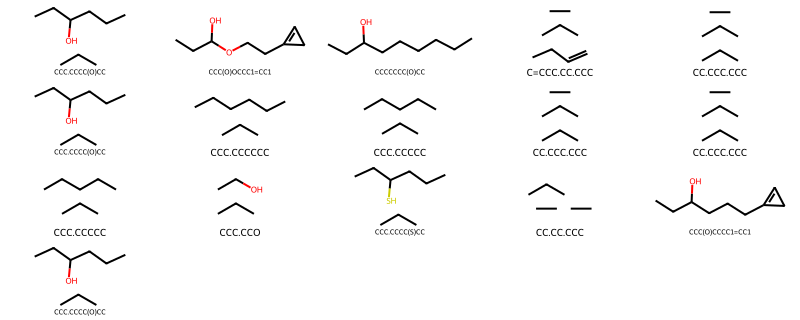

Text(value='my_molecules.png', description='Filename:')

Button(description='Save Image', style=ButtonStyle())

Text(value='generated_molecules.csv', description='CSV Filename:')

Button(description='Save CSV', style=ButtonStyle())

SMILES and properties saved to generated_molecules.csv


In [62]:
# Sample novel molecules with the generator
'''
This function is the final step in the process, where we use the trained generator to create
new molecules. Here is the breakdown:

1. Generating random input(z):
    - tf.random.normal: This creates a tensor (z) filled with random numbers drawn from a
      normal distribution.
    - (batch_size, LATENT_DIM): This specifies the shape of the tensor. batch_size controls how
      many molecules to generate at once, and LATENT_DIM is the size of the latent space (a
      lower-dimensional representation of the molecule).
2. Predicting molecular graphs (graph):
    - generator.predict: This uses the trained generator model to transform the random input
      (z) into a predicted molecular graph representation (graph). The graph contains
      information about the atoms and bonds in the generated molecule.
3. Processing adjacency tensor (adjacency):
    - tf.argmax: This finds the index of the highest value along the specified axis (axis=1) of
      graph[0] (the adjacency part of the graph). This essentially determines the type of bond
      between atoms.
    - tf.one_hot: This converts the bond type indices into a one-hot encoded representation
      (adjacency). This makes it easier for the model to work with.
    - tf.linalg.set_diag: This sets the diagonal elements of the adjacency tensor to zeros,
      ensuring there are no self-loops (atoms bonded to themselves).
4. Processing feature tensor (feature):
    - tf.argmax: Similar to the adjacency processing, this finds the index of the highest value
      in graph[1] (the features part), representing the atom type.
    - tf.one_hot: This converts the atom type indices into a one-hot encoded representation
      (features).
5. Creating molecule objects:
    - graph_to_molecule: This helper function takes the processed adjacency and features
      tensors and converts them into a RDKit molecule object, which is a standard way to
      represent molecules in cheminformatics.
    - The code iterates through the batch_size and creates a molecule object for each generated
      molecule, returning a list of these objects.
'''
def sample(generator, batch_size):
    z = tf.random.normal((batch_size, LATENT_DIM))
    graph = generator.predict(z)
    # obtain one-hot encoded adjacency tensor
    adjacency = tf.argmax(graph[0], axis=1)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
    # Remove potential self-loops from adjacency
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
    # obtain one-hot encoded feature tensor
    features = tf.argmax(graph[1], axis=2)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
    return [
        graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
        for i in range(batch_size)
    ]

# Calculate molecular properties of the GAN generated smiles
def calculate_and_save_properties_from_smiles(smiles_list, filename="generated_molecules.csv", print_messages=True):
    """
    Calculates QED for a list of SMILES strings and saves SMILES and QED to a CSV file.

    Args:
        smiles_list: A list of SMILES strings.
        filename: The name of the CSV file to save the data to.
    """

    data_to_save = []
    valid_molecules = []
    existing_smiles = set() # To store existing SMILES from the csv

    # Load existing SMILES from the CSV file if it exists
    try:
        with open(filename, 'r', newline='') as csvfile:
            reader = csv.reader(csvfile)
            next(reader)  # Skip header row
            for row in reader:
                existing_smiles.add(row[0])  # Add SMILES from the first column
    except FileNotFoundError:
        pass  # If file doesn't exist, continue

    for smiles in smiles_list:
        if smiles not in existing_smiles: # Check for duplicates
          mol = Chem.MolFromSmiles(smiles)
          if mol is not None:
            try:
                qed_value = QED.qed(mol)  # Calculate QED
                if qed_value >= 0.492: # Check if QED is greater than or equal to 0.492
                  logp_value = Crippen.MolLogP(mol)  # Calculate logP
                  sas_value = sascorer.calculateScore(mol)  # Calculate SAS
                  molwt_value = Descriptors.MolWt(mol)  # Calculate molecular weight
                  data_to_save.append([smiles, qed_value, logp_value, sas_value, molwt_value])
                  valid_molecules.append(mol) # Add to valid molecules list
                  existing_smiles.add(smiles) # Add to the set if it was new and the mol was successfully created
                else:
                  if print_messages:
                    print(f"Molecules with low QED score encountered: {smiles}. Score: {qed_value}")
            except:
              if print_messages:
                print(f"Error calculating properties for SMILES: {smiles}")
        else:
          if print_messages:
            print(f"Invalid SMILES encountered: {smiles}")

    with open(filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        if csvfile.tell() == 0:
          writer.writerow(["smiles", "qed", "logP", "sas", "MolWt"])  # Write header if file is empty
        writer.writerows(data_to_save)  # Write new data rows

    # Return valid molecules for image generation
    return valid_molecules

def save_csv(b):
    filename = csv_filename_widget.value
    calculate_and_save_properties_from_smiles(legends, filename=filename, print_messages=False)  # Pass filename to the function
    print(f"SMILES and properties saved to {filename}")

# Create a text box widget for filename input
filename_widget = widgets.Text(value="my_molecules.png", description="Filename:")
csv_filename_widget = widgets.Text(value="generated_molecules.csv", description="CSV Filename:")

def save_image(b):
    img_filename = filename_widget.value
    img_to_save = Image.open(io.BytesIO(pil_img.data))
    img_to_save.save(img_filename) # call 'save' on PIL Image, this will overwrite the existing file if it has the same name.

    print(f"Image saved as {img_filename}")

molecules = sample(wgan.generator, batch_size=16)

# Generate SMILES legends for valid molecules
legends = [Chem.MolToSmiles(m) for m in molecules if m is not None]

# Filter molecules based on QED score before creating image
valid_molecules_for_image = calculate_and_save_properties_from_smiles(legends, filename=csv_filename_widget.value, print_messages=True)
pil_img = MolsToGridImage(
    [m for m in molecules if m is not None], molsPerRow=5, subImgSize=(160, 80), legends=legends
)
display(pil_img)

display(filename_widget)
 # Create a button to trigger saving
save_button = widgets.Button(description="Save Image")
save_button.on_click(save_image)
display(save_button)

display(csv_filename_widget)
# Create a button to trigger saving the CSV
save_csv_button = widgets.Button(description="Save CSV")
save_csv_button.on_click(save_csv)
display(save_csv_button)